# Aufgabe
Bei diesem Datensatz handelt es sich um ein Produkt der Gussherstellung.
Gießen ist ein Herstellungsverfahren, bei dem ein flüssiges Material in der Regel in eine Form gegossen wird, die einen Hohlraum in der gewünschten Form enthält, und dann erstarren gelassen wird.
Der Grund für die Erhebung dieser Daten sind Gussfehler!
Ein Gussfehler ist eine unerwünschte Unregelmäßigkeit in einem Metallgussverfahren.
Es gibt viele Arten von Gussfehlern, wie z. B. Lunker, Nadellöcher, Grate, Schrumpfungsfehler, Formstofffehler, Gussmetallfehler, metallurgische Fehler, usw.
Defekte sind in der Gießereiindustrie ein unerwünschtes Phänomen. Um diese fehlerhaften Produkte zu beseitigen, haben alle Industriezweige ihre Qualitätsprüfungsabteilung. Das Hauptproblem ist jedoch, dass dieser Prüfprozess manuell durchgeführt wird. Dies ist ein sehr zeitaufwändiger Prozess, der aufgrund der menschlichen Genauigkeit nicht 100%ig genau ist. Dies kann dazu führen, dass eine gesamte Bestellung abgelehnt wird. Dadurch entsteht ein großer Verlust für das Unternehmen.

Wir haben beschlossen, den Inspektionsprozess zu automatisieren, und dafür müssen wir ein Deep-Learning-Klassifizierungsmodell für dieses Problem erstellen.

## Datenbeschreibung
Diese Fotos zeigen das Laufrad einer Tauchpumpe in der Draufsicht (Google-Suche zum besseren Verständnis).
Der Datensatz enthält insgesamt 7348 Bilddaten. Diese haben alle die Größe von (300*300) Pixeln und sind grau skaliert. Bei allen Bildern wurde bereits eine Vergrößerung vorgenommen.

Auch die hochgeladenen Bilder haben eine Größe von 512x512 Graustufen. Dieser Datensatz ist ohne Augmentation. Er enthält 519 ok_front und 781 def_front Laufradbilder.

Für die Aufnahme dieser Bilder ist eine stabile Beleuchtung erforderlich, für die wir eine spezielle Anordnung getroffen haben.

Es gibt zwei Kategorien:
1) Defekt (def_front)
2) In Ordnung (ok_front)

Bei der Erstellung des Klassifizierungsmodells haben wir die Daten für Training und Test bereits in zwei Ordner aufgeteilt.
Die beiden Ordner train und test enthalten die Unterordner def_front und ok_front.

train:- def_front hat 3758 und ok_front hat 2875 Bilder
test:- def_front hat:- def_front hat 453 und ok_front hat 262 Bilder

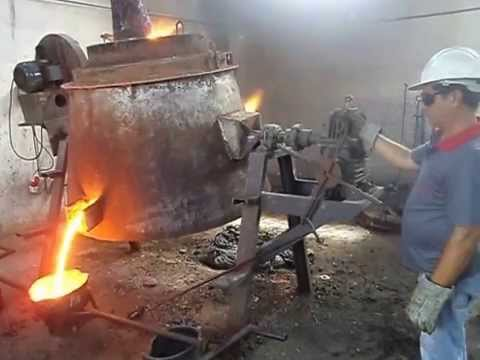

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("4Lo3tcrz8U0")

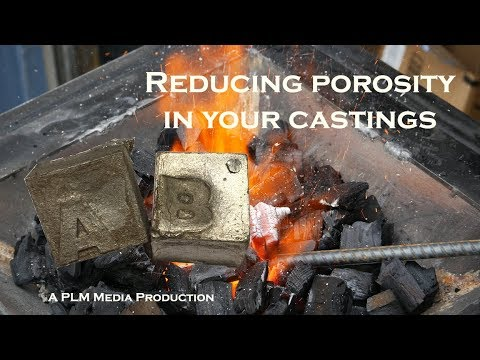

In [2]:
YouTubeVideo("OmmEXUnL4_8")

In [200]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# from torchviz import make_dot
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image



import holoviews as hv
from holoviews import opts
#hv.extension('bokeh')
import json
import shap

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# load data

In [4]:
my_data_dir = f'./data/casting_detect/casting_data/casting_data/'
train_path = my_data_dir + 'train/'
test_path = my_data_dir + 'test/'

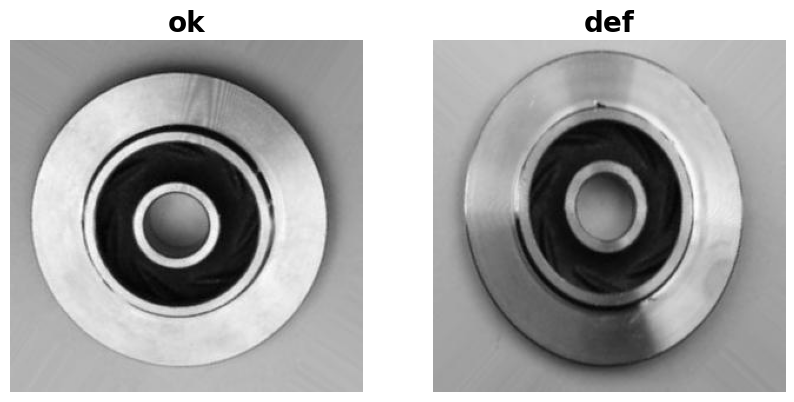

In [5]:
plt.figure(figsize=(10,8))
ok = plt.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

ng = plt.imread(train_path + 'def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

# Datevorverarbeitung
Beim Training mit Bilddaten ohne Datenaugmentation müssen wir nur die Datenmenge angeben und einen Mini-Batch erstellen. Bei der Datenaugmentation werden nach der Datenerfassung verschiedene Augmentationstechniken auf die Bilder angewendet, um neue Mini-Batches zu erstellen.
Die wichtigsten Parameter der Datenaugmentation (Keras ImageDataGenerator) sind wie folgt:

- rotation_range : Drehen des Bildes (z.B. 50 -> zufälliges Drehen im Bereich -50°~50°)
- zoom_range : Vergrößern/Verkleinern des Bildes (z.B. 0.5 -> 1-0.5~1+0.5 zufällig vergrößern/verkleinern)
- brightness_range : Helligkeit ändern (z.B. [0.3,1.0] -> zufällige Änderung im Bereich [0.3,1.0])
- vertical_flip : spiegelt das Bild auf den Kopf
- horizontal_flip : spiegelt das Bild nach links oder rechts
- height_shift_range : verschiebt das Bild parallel nach oben oder unten (z.B. 0.3 -> zufällig nach oben/unten in [-0.3*Höhe, 0.3*Höhe] )
- width_shift_range : Bild parallel nach links oder rechts verschieben (z.B. 0.3 -> zufällige Verschiebung nach links/rechts in [-0.3*Width, 0.3*Width] )
- rescale : Normalisiert das Bild durch Multiplikation jedes Pixelwertes mit einer Konstante. (z.B. 1/255 -> normalisiert den RGB-Wert jedes Pixels zwischen 0,0 und 1,0)

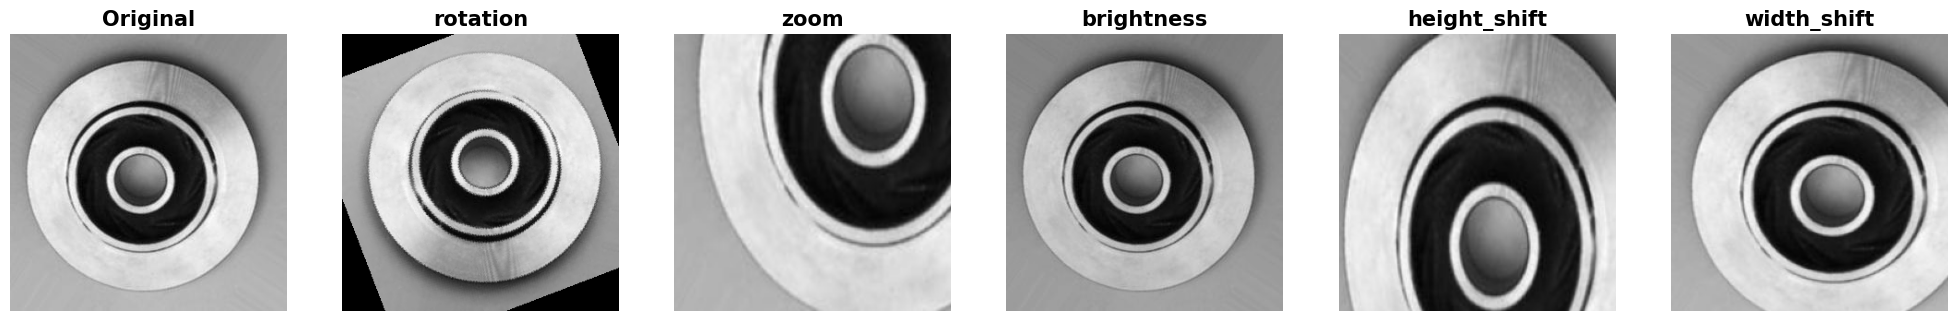

In [6]:
## take a look at the augmented data
# Read the image
img = cv2.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')  # load data
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV读取的是BGR格式，转换为RGB格式

# Initialize the plot
plt.figure(figsize=(25, 10))

# Original Image
plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')

# Define transformations (augmentations)
generators = {
    "rotation": transforms.RandomRotation(180),
    "zoom": transforms.RandomResizedCrop(224, scale=(0.3, 1.0)),
    "brightness": transforms.ColorJitter(brightness=[0.2, 1.0]),
    "height_shift": transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.5, 1.5)),
    "width_shift": transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.5, 1.5))
}

cnt = 2
for param, transform in generators.items():
    pil_img = Image.fromarray(img)
    transformed_img = transform(pil_img)
    transformed_img_np = np.array(transformed_img)

    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(transformed_img_np)
    plt.axis('off')
    cnt += 1

# Show plot
plt.show()


In [7]:
## create dataload with data augmentation 
# Set parameters
image_shape = (300, 300)
batch_size = 32

# Image transformations
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=[0.9, 1.0]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
])

# Create train and validation loader

dataset = datasets.ImageFolder(train_path, transform=transform, 
                                     is_valid_file=lambda x: x.endswith('.jpeg'))  # Or any other image extension you're using

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# create test loader

test_dataset = datasets.ImageFolder(test_path, transform=transform, 
                                    is_valid_file=lambda x: x.endswith('.jpeg'))  # Or any other image extension you're using
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Set class mappings manually
train_dataset.class_to_idx = {'def_front': 0, 'ok_front': 1}
test_dataset.class_to_idx = {'def_front': 0, 'ok_front': 1}


To simply the process, we use the same transformation for both test set and train set

# Modelling
增加对模型的介绍
## simple cnn

In [8]:


class SimpleCNN(nn.Module):
    def __init__(self, image_shape):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(image_shape[2], 16, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(64 * (image_shape[0] // 8) * (image_shape[1] // 8), 224)
        self.fc1 = nn.Linear(20736, 224) # magic number
        self.fc2 = nn.Linear(224, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        #x = self.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# Create the model
image_shape = (300, 300, 1)  # H x W x C
model = SimpleCNN(image_shape)

# Loss and optimizer
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Display model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [12]:
# # Create a dummy input that matches the input dimensions of the model
# # Assuming the model expects (batch_size, channels, height, width)
# dummy_input = torch.randn(1, 1, 300, 300)  # Here, batch_size = 1, channels (grayscale) = 1, height = 300, width = 300

# # Make sure your model is on the same device as the dummy input
# model = model.to('cpu') 

# # Forward pass with dummy input
# output = model(dummy_input)

# # Visualize the computational graph
# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.render("model_graph", format="png", cleanup=True)

class EarlyStopping:
    def __init__(self, patience=2, out_path = 'casting_product_detection.pth', verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.out_path = out_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.out_path)
        self.val_loss_min = val_loss

def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= total
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return val_loss, accuracy, f1

# Initialize early stopping and model checkpoint
early_stopping = EarlyStopping(patience=2, verbose=True)

n_epochs = 20
model_history = {'loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs.shape, outputs)
        #loss = criterion(outputs.squeeze(1), labels.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    model_history['loss'].append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loss, accuracy, f1 = validate(model, val_loader)
    
    model_history['val_loss'].append(val_loss)
    model_history['val_acc'].append(accuracy)
    model_history['val_f1'].append(f1)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Acc: {accuracy}, F1: {f1}')

    # Early stopping and model checkpointing
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save model history to JSON
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)


  0%|          | 0/166 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [10]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.tail(3)

,loss,val_loss,val_acc,val_f1
16,0.039549,0.001184,98.568199,0.985460
17,0.054499,0.002478,97.889977,0.978500
18,0.035944,0.001245,99.095705,0.990815


In [ ]:
g = hv.Curve(losses.loss, label='Training Loss') * hv.Curve(losses.val_loss, label='Validation Loss') \
     * hv.Curve(losses.val_acc, label='Validation Accuracy')
g.opts(opts.Curve(xlabel="Epochs", ylabel="Loss / Accuracy", width=700, height=400,tools=['hover'],show_grid=True,title='Model Evaluation')).opts(legend_position='bottom')

In [16]:
#print(classification_report(test_set.classes, predictions, digits=3))

In [14]:
validate(model, test_loader)

(0.0005447530005614833, 99.44055944055944, 0.9939853292506478)

Wir sehen, dass die Genauigkeit des Modells bei der Testmenge 99,4 % beträgt. Ob dieses Ergebnis jedoch zufriedenstellend ist, sollte auch auf der Grundlage des Problems analysiert werden. Gegebenenfalls können die Kategoriegewichte kombiniert werden, um das Modell stärker in Richtung Recall oder Precision zu beeinflussen. Darüber hinaus kann das Training gezielter Modelle oder die Verwendung von tta usw. die Modellleistung weiter verbessern.

# Intepretation

In [74]:
# Select image samples
image = Image.open(train_path + 'def_front/cast_def_0_1001.jpeg')
#image = Image.open(train_path + 'ok_front/cast_ok_0_1019.jpeg')

In [75]:
model.load_state_dict(torch.load('casting_product_detection.pth'))

<All keys matched successfully>

In [76]:
## define prediction function
def predict_fn(images):
    model.eval()
    image_shape = [300, 300]
    transform_test = transforms.Compose([
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
    ])
    # transform_test = transforms.Compose([
    #     transforms.Resize(image_shape),
    #     transforms.Grayscale(num_output_channels=1),
    #     transforms.RandomAffine(0, translate=(0.1, 0.1)),
    #     transforms.ColorJitter(brightness=[0.9, 1.0]),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
    # ])

    
    #|print(image.shape)
    #batch = transform_test(Image.fromarray(image, 'RGB').convert('L')).unsqueeze(dim = 0)
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis = 0)
    batch = torch.stack(tuple(transform_test(Image.fromarray(image, 'RGB').convert('L')) for image in images), dim=0)
    with torch.no_grad():
        outputs = model(batch)
        probabilities = torch.softmax(outputs, dim=1)
        
    return probabilities.cpu().numpy()

In [77]:
predict_fn(np.array(image.convert("RGB")))

array([[1.0000000e+00, 3.3541845e-08]], dtype=float32)

In [78]:
# Initializing the LIME Interpreter
explainer = lime_image.LimeImageExplainer()

# Define the image segmentation algorithm
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# Get an explanation
explanation = explainer.explain_instance(
    np.array(image.convert("RGB")), 
    classifier_fn=predict_fn, 
    segmentation_fn=segmenter
)

# Explanation of Display
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

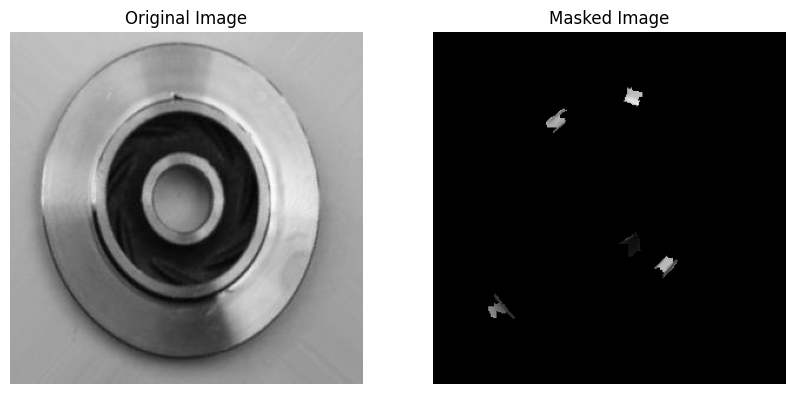

In [79]:
# Applying a mask to the original image
original_image = np.array(image.convert("RGB"))

masked_image = np.zeros_like(original_image)
for i in range(3):
    masked_image[:,:,i] = original_image[:,:,i] * mask

# Display original image and image with mask
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Masked Image')
plt.imshow(masked_image)
plt.axis('off')

plt.show()

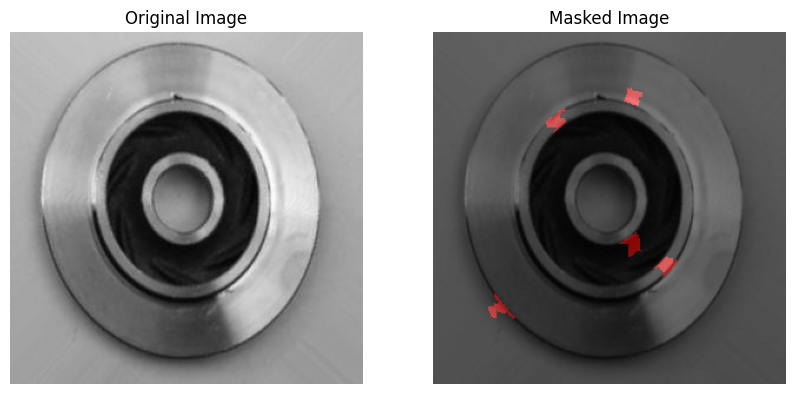

In [80]:
# Creates an all-red image the same size as the original image
overlay = np.zeros_like(original_image)
overlay[:,:,0] = 255  # 红色通道

# Apply a mask to the overlay to make it semi-transparent
masked_overlay = np.zeros_like(original_image)
for i in range(3):  # 对于 RGB 的每一个通道
    masked_overlay[:,:,i] = overlay[:,:,i] * mask

# Add a translucent overlay to the original image
masked_image = original_image.copy()
alpha = 0.5  # Setting transparency
masked_image = cv2.addWeighted(masked_image, 1 - alpha, masked_overlay, alpha, 0)

# Displays the original image and the tagged image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Masked Image')
plt.imshow(masked_image)
plt.axis('off')

plt.show()


# Lokalisierung
Zwei Methoden:
- Verwendung des Autoencoders, um den Decoder-Ausgang mit einer Softmax zu verbinden (Maske erzeugen) und dann mit einem Vorhersagekopf zu verbinden.
- Eine Attentionmethode, um die vorhergesagten relevanten Bereiche herauszufinden.


In [202]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (b, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (b, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # (b, 64, 1, 1)
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # (b, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (b, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # (b, 1, 28, 28)
            nn.Sigmoid(),  # Output range [0, 1]
            #nn.ReLU()
        )
        
        # predictor
        self.conv1 = nn.Conv2d(image_shape[2], 16, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(20736, 224) # magic number
        self.fc2 = nn.Linear(224, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        

    def forward(self, x):
        # masked logits
        mask_logits = self.decoder(self.encoder(x))
                
        # Using Gumbel-Softmax to Generate Approximate Hard Masks
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(mask_logits) + 1e-9) + 1e-9)
        mask = F.softmax((mask_logits + gumbel_noise) / 0.5, dim=-1)
        hard_mask = (mask > 0.5).float()
        
        x = x * hard_mask
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        #x = self.sigmoid(self.fc2(x))
        x = self.fc2(x)
        
        return x, hard_mask


        
def build_model(opt, lr, out_type):
    model = CustomCNN()
    
    if opt == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif opt == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    
    if out_type == "classify":
        return model, optimizer, criterion
    else:
        raise ValueError("Map output not supported in this PyTorch version")

# Example of usage
opt = "Adam"
lr = 0.001
out_type = "classify"
model, optimizer, criterion = build_model(opt, lr, out_type)
model

CustomCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=2, bias=True)
  (po

In [20]:
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            # Move your inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            #loss = criterion(outputs.squeeze(1), labels.float())
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= total
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return val_loss, accuracy, f1

In [32]:
# Initialize early stopping and model checkpoint
early_stopping = EarlyStopping(patience=2, out_path = 'casting_product_detection2.pth', verbose=True)

n_epochs = 20
model_history = {'loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        #print(outputs.shape, labels.shape)
        #loss = criterion(outputs.squeeze(1), labels.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    model_history['loss'].append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loss, accuracy, f1 = validate(model, val_loader)
    
    model_history['val_loss'].append(val_loss)
    model_history['val_acc'].append(accuracy)
    model_history['val_f1'].append(f1)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Acc: {accuracy}, F1: {f1}')

    # Early stopping and model checkpointing
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save model history to JSON
with open('model_history2.json', 'w') as f:
    json.dump(model_history, f, indent=4)

  1%|          | 1/166 [00:04<13:10,  4.79s/it]


KeyboardInterrupt: 

Mit zunehmender Komplexität des Modells die Zeit zum Trainieren des Modells erheblich steigt. In diesem Fall können wir die GPU zum Trainieren des Modells verwenden.

In [210]:
# Determine if a GPU is available and if not, revert to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move your model to the device
model = model.to(device)

# Initialize early stopping and model checkpoint
early_stopping = EarlyStopping(patience=10, out_path='casting_product_detection2.pth', verbose=True)

n_epochs = 100
model_history = {'loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    
    for batch in tqdm(train_loader):
        inputs, labels = batch

        # Move your inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, mask = model(inputs)
        
        #loss = criterion(outputs.squeeze(1), labels.float())
        loss = criterion(outputs, labels)
        
        # add regulization
        #print(torch.norm(mask, 1), loss)
        #loss += 1e-5 * torch.norm(mask, 1)
        
        # update
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    model_history['loss'].append(train_loss)
    
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_loss, accuracy, f1 = validate(model, val_loader, device)  # Make sure your validate function is also GPU-compatible
    
    model_history['val_loss'].append(val_loss)
    model_history['val_acc'].append(accuracy)
    model_history['val_f1'].append(f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Acc: {accuracy}, F1: {f1}')

    # Early stopping and model checkpointing
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save model history to JSON
with open('model_history2.json', 'w') as f:
    json.dump(model_history, f, indent=4)


100%|██████████| 166/166 [00:03<00:00, 53.04it/s]


Epoch 1, Train Loss: 0.24244820542005172, Val Loss: 0.007119600602847432, Acc: 91.10776186887716, F1: 0.9095760899192002
Validation loss decreased (inf --> 0.007120).  Saving model ...


100%|██████████| 166/166 [00:03<00:00, 53.25it/s]


Epoch 2, Train Loss: 0.24427821505141545, Val Loss: 0.007378447382586651, Acc: 91.78598342125095, F1: 0.9163890579686269
EarlyStopping counter: 1 out of 10


100%|██████████| 166/166 [00:03<00:00, 51.14it/s]


Epoch 3, Train Loss: 0.2618789489728859, Val Loss: 0.007501089958068385, Acc: 90.5802562170309, F1: 0.9040369007404562
EarlyStopping counter: 2 out of 10


100%|██████████| 166/166 [00:03<00:00, 53.00it/s]


Epoch 4, Train Loss: 0.2516543611390404, Val Loss: 0.008096058033940121, Acc: 89.97739261492087, F1: 0.8987100221357148
EarlyStopping counter: 3 out of 10


100%|██████████| 166/166 [00:03<00:00, 54.27it/s]


Epoch 5, Train Loss: 0.2515008887163846, Val Loss: 0.007360554658881506, Acc: 89.90203466465712, F1: 0.8984082910553498
EarlyStopping counter: 4 out of 10


100%|██████████| 166/166 [00:03<00:00, 53.50it/s]


Epoch 6, Train Loss: 0.24953239148550005, Val Loss: 0.007112680765229594, Acc: 90.88168801808591, F1: 0.9078489675069286
Validation loss decreased (0.007120 --> 0.007113).  Saving model ...


100%|██████████| 166/166 [00:03<00:00, 52.80it/s]


Epoch 7, Train Loss: 0.26142416279538566, Val Loss: 0.007354705694841099, Acc: 91.40919366993218, F1: 0.9129036492517721
EarlyStopping counter: 1 out of 10


100%|██████████| 166/166 [00:03<00:00, 50.78it/s]


Epoch 8, Train Loss: 0.2519370233976697, Val Loss: 0.007151730611257834, Acc: 91.40919366993218, F1: 0.9128406220616162
EarlyStopping counter: 2 out of 10


100%|██████████| 166/166 [00:03<00:00, 49.02it/s]


Epoch 9, Train Loss: 0.24323433597224303, Val Loss: 0.006669156966392672, Acc: 92.31348907309722, F1: 0.9222317981246553
Validation loss decreased (0.007113 --> 0.006669).  Saving model ...


100%|██████████| 166/166 [00:03<00:00, 53.84it/s]


Epoch 10, Train Loss: 0.24685677769313374, Val Loss: 0.00710301012496977, Acc: 91.10776186887716, F1: 0.9102292740648333
EarlyStopping counter: 1 out of 10


100%|██████████| 166/166 [00:03<00:00, 52.19it/s]


Epoch 11, Train Loss: 0.24409426510872612, Val Loss: 0.006545692463296647, Acc: 92.38884702336097, F1: 0.9229558528247375
Validation loss decreased (0.006669 --> 0.006546).  Saving model ...


100%|██████████| 166/166 [00:03<00:00, 50.31it/s]


Epoch 12, Train Loss: 0.2455184820994555, Val Loss: 0.009084033635925689, Acc: 87.64129615674453, F1: 0.8763269277105694
EarlyStopping counter: 1 out of 10


100%|██████████| 166/166 [00:03<00:00, 51.61it/s]


Epoch 13, Train Loss: 0.2557938998363104, Val Loss: 0.008260774186839712, Acc: 88.62094951017332, F1: 0.8838279040994788
EarlyStopping counter: 2 out of 10


100%|██████████| 166/166 [00:03<00:00, 51.77it/s]


Epoch 14, Train Loss: 0.2505949659789183, Val Loss: 0.00770492487907769, Acc: 90.27882441597589, F1: 0.902255149672391
EarlyStopping counter: 3 out of 10


100%|██████████| 166/166 [00:03<00:00, 53.55it/s]


Epoch 15, Train Loss: 0.24000322450715375, Val Loss: 0.0064457979982476, Acc: 91.33383571966843, F1: 0.9127387526167511
Validation loss decreased (0.006546 --> 0.006446).  Saving model ...


100%|██████████| 166/166 [00:03<00:00, 50.10it/s]


Epoch 16, Train Loss: 0.2416256677853056, Val Loss: 0.0074077757481084165, Acc: 90.5802562170309, F1: 0.9052859977445649
EarlyStopping counter: 1 out of 10


100%|██████████| 166/166 [00:03<00:00, 52.93it/s]


Epoch 17, Train Loss: 0.23893221808844303, Val Loss: 0.00717987707439184, Acc: 91.40919366993218, F1: 0.9130246303152957
EarlyStopping counter: 2 out of 10


100%|██████████| 166/166 [00:03<00:00, 52.89it/s]


Epoch 18, Train Loss: 0.23914719413382463, Val Loss: 0.007025617822589242, Acc: 91.93669932177845, F1: 0.9179564014276692
EarlyStopping counter: 3 out of 10


100%|██████████| 166/166 [00:03<00:00, 54.36it/s]


Epoch 19, Train Loss: 0.23264708239809576, Val Loss: 0.006660749864874698, Acc: 92.0120572720422, F1: 0.9183943655434883
EarlyStopping counter: 4 out of 10


100%|██████████| 166/166 [00:03<00:00, 51.42it/s]


Epoch 20, Train Loss: 0.24504363931805254, Val Loss: 0.006578137080473566, Acc: 92.23813112283347, F1: 0.9210234518415881
EarlyStopping counter: 5 out of 10


100%|██████████| 166/166 [00:03<00:00, 50.84it/s]


Epoch 21, Train Loss: 0.2429207688175052, Val Loss: 0.0070488855955783995, Acc: 91.78598342125095, F1: 0.9169617971335651
EarlyStopping counter: 6 out of 10


100%|██████████| 166/166 [00:03<00:00, 54.23it/s]


Epoch 22, Train Loss: 0.25304863209196604, Val Loss: 0.006524473803501068, Acc: 92.1627731725697, F1: 0.9204568509194193
EarlyStopping counter: 7 out of 10


100%|██████████| 166/166 [00:03<00:00, 47.55it/s]


Epoch 23, Train Loss: 0.2326406329780458, Val Loss: 0.007045783501149302, Acc: 91.10776186887716, F1: 0.9094669287696577
EarlyStopping counter: 8 out of 10


100%|██████████| 166/166 [00:03<00:00, 51.34it/s]


Epoch 24, Train Loss: 0.23369153467826095, Val Loss: 0.007070827833359279, Acc: 91.25847776940468, F1: 0.9113437924758678
EarlyStopping counter: 9 out of 10


100%|██████████| 166/166 [00:03<00:00, 51.95it/s]


Epoch 25, Train Loss: 0.23633744908743595, Val Loss: 0.006645834181505482, Acc: 91.40919366993218, F1: 0.9126065857885615
EarlyStopping counter: 10 out of 10
Early stopping


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplot

def plot_maps(images, maps, k, dims):
    map_size, r_size, r_stride = dims
    colors = ['#ff0000', '#ff0080', '#ff00ff', '#8000ff', '#0080ff', '#00ffff', '#00ff80']
              
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for j, (img, mask) in enumerate(zip(images, maps)):
        j_a, j_b = divmod(j, 3)
        
        # Convert PyTorch tensor to numpy array and normalize
        img = img[0].cpu().numpy().astype(np.float32) / 255.0
        mask = mask.cpu().numpy().flatten()
        
        ax[j_a][j_b].imshow(img, cmap=plt.get_cmap('gray'))
        
        for i in range(k):
            a_max = np.argmax(mask)
            x_region, y_region = divmod(a_max, map_size)
            prob = mask[a_max]
            
            if prob < 0.5:
                break
            
            x_pixel = r_stride * x_region
            y_pixel = r_stride * y_region
            
            # Draw rectangle on the image
            rectangle = mplot.patches.Rectangle((x_pixel, y_pixel), r_size, r_size, edgecolor=colors[i], facecolor="none")
            ax[j_a][j_b].add_patch(rectangle)
            
            font = {'color': colors[i]}
            ax[j_a][j_b].text(x_pixel, y_pixel, s="{0:.3f}".format(prob), fontdict=font)
            
            # Zero out the current max value in mask
            mask[a_max] = 0

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


In [213]:
validate(model, test_loader, device)

(0.006816638261079788, 91.60839160839161, 0.9106056312200976)

## Overlay Plot

In [170]:
def predict_fn(images, device):
    model.eval()
    image_shape = [300, 300]
    transform_test = transforms.Compose([
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
    ])
    
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis = 0)
    batch = torch.stack(tuple(transform_test(Image.fromarray(image, 'RGB').convert('L')) for image in images), dim=0).to(device)
    model.to(device)
    
    with torch.no_grad():
        outputs, mask = model(batch)
        #probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
    return predicted.cpu().numpy(), mask.cpu().numpy()

In [204]:
image = Image.open(train_path + 'def_front/cast_def_0_1001.jpeg')

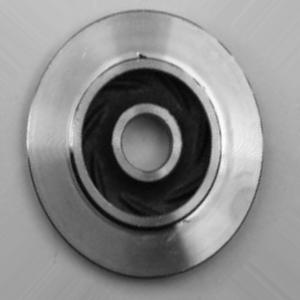

In [205]:
Image.fromarray(np.array(image))

In [211]:
pred, mask = predict_fn(np.array(image), device)
mask = mask.squeeze()

In [188]:
threshold = 0
mask = (mask > threshold)

In [208]:
original_image = np.array(image)

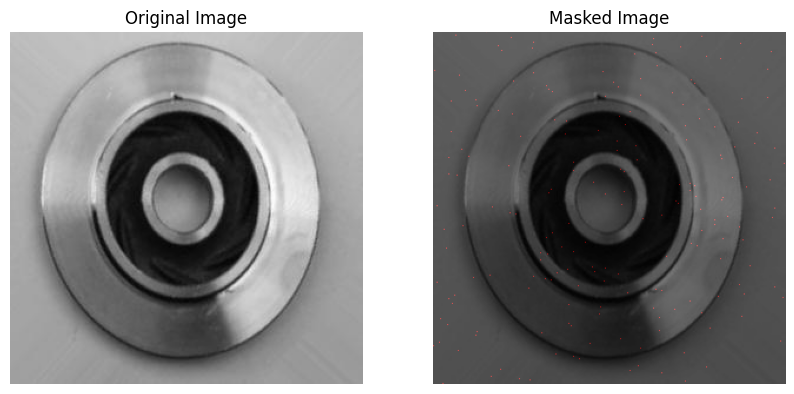

In [209]:
# Without drawing a frame, take a look at what the mask looks like.
# Creates an all-red image the same size as the original image
overlay = np.zeros_like(original_image)
overlay[:,:,0] = 255  # red channel

# Apply a mask to the overlay to make it semi-transparent
i = 0
masked_overlay = np.zeros_like(original_image)
for i in range(3):  # For each channel of RGB
    masked_overlay[:,:,i] = overlay[:,:,i] * mask

# Add a translucent overlay to the original image
masked_image = original_image.copy()
alpha = 0.5  # Setting transparency
masked_image = cv2.addWeighted(masked_image, 1 - alpha, masked_overlay, alpha, 0)

# Displays the original image and the tagged image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Masked Image')
plt.imshow(masked_image)
plt.axis('off')

plt.show()

In [185]:
mask.shape

(300, 300)

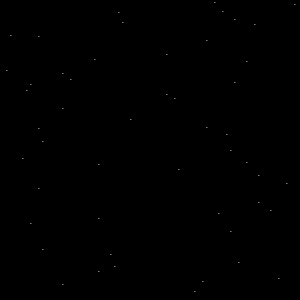

In [212]:
Image.fromarray(mask.squeeze(), 'L')